## Análise de Vendas de Videogames – Projeto Ice Store

### Contexto  
A loja online Ice comercializa videogames globalmente e deseja entender quais fatores influenciam o sucesso de um jogo para apoiar decisões estratégicas de marketing e planejamento de campanhas.

### Objetivo  
Identificar padrões que determinam o sucesso de jogos eletrônicos, analisando vendas, plataformas, gêneros e avaliações de usuários e críticos, com foco no planejamento de campanhas para o ano de 2017.

### Perguntas de negócio  
- Quais plataformas e gêneros apresentam maior potencial de vendas?  
- Como as avaliações de usuários e críticos se relacionam com o desempenho comercial?  
- Existem diferenças significativas entre regiões de mercado?  


### Estrutura da análise

1. Carregamento e preparação dos dados  
2. Análise exploratória das vendas ao longo do tempo  
3. Comparação de desempenho entre plataformas  
4. Análise de gêneros e vendas globais  
5. Impacto das avaliações de usuários e críticos  
6. Perfil de mercado por região (NA, UE, JP)  
7. Testes de hipóteses estatísticas  
8. Conclusão e recomendações de negócio


## 1. Carregamento e preparação dos dados





Nesta etapa, os dados são carregados e preparados para a análise. 
Foram realizadas padronizações nos nomes das colunas, conversões de tipos de dados 
e tratamento de valores ausentes, garantindo consistência e confiabilidade para as 
análises exploratórias e estatísticas subsequentes.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


In [2]:
df = pd.read_csv('/datasets/games.csv')


In [3]:
df.head()


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
df.describe()


,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


## 2. Análise exploratória das vendas ao longo do tempo






A análise das vendas ao longo do tempo mostra que o volume de lançamentos e vendas
varia significativamente entre os anos. Observa-se um crescimento até determinado
período, seguido por uma retração, o que indica ciclos naturais da indústria de
videogames e a substituição gradual de plataformas ao longo do tempo.


### 2.1 Padronizar nomes das colunas

In [6]:

df.columns = df.columns.str.lower()
df.columns


Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### 2.2 Verificar tipos de dados

In [7]:
df.dtypes



name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

### 2.3 Converter tipos de dados

In [8]:
df['year_of_release'] = pd.to_numeric(df['year_of_release'], errors='coerce')


In [9]:
df['user_score'] = df['user_score'].replace('tbd', np.nan)
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')


### 2.4 Verificar valores ausentes

In [10]:
df.isna().sum()


name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

### 2.5 Tratamento dos valores ausentes

In [11]:
df = df.dropna(subset=['year_of_release'])


In [12]:
df = df.dropna(subset=['name', 'genre'])


### 2.6 Criar coluna de vendas globais

In [13]:
df['global_sales'] = (
    df['na_sales'] +
    df['eu_sales'] +
    df['jp_sales'] +
    df['other_sales']
)


### 2.7 Conferências finais

In [14]:
df.dtypes


name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
global_sales       float64
dtype: object

In [15]:
df.isna().sum()


name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating             6676
global_sales          0
dtype: int64

In [16]:
df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'global_sales']].head()


,na_sales,eu_sales,jp_sales,other_sales,global_sales
0,41.36,28.96,3.77,8.45,82.54
1,29.08,3.58,6.81,0.77,40.24
2,15.68,12.76,3.79,3.29,35.52
3,15.61,10.93,3.28,2.95,32.77
4,11.27,8.89,10.22,1.00,31.38


### Preparação dos dados

- Os nomes das colunas foram convertidos para letras minúsculas para padronização.
- A coluna **year_of_release** foi convertida para numérica para permitir análises temporais.
- A coluna **user_score** continha valores 'tbd', que não representam pontuações válidas, e foram substituídos por NaN.
- Linhas com valores ausentes em **year_of_release**, **name** e **genre** foram removidas, pois são essenciais para a análise.
- Valores ausentes em **critic_score**, **user_score** e **rating** foram mantidos, não é apropriado substituí-los artificialmente, pois isso poderia distorcer os resultados da análise.
- Foi criada a coluna **global_sales**, representando a soma das vendas em todas as regiões.


## 3. Desempenho de vendas por plataforma


A análise por plataforma evidencia que o ciclo de vida dos consoles influencia
diretamente o desempenho de vendas. Algumas plataformas apresentam picos claros
de popularidade seguidos por declínio, enquanto outras demonstram crescimento
recente, indicando maior potencial para campanhas futuras.


### 3.1 Quantidade de jogos lançados por ano

In [17]:

games_per_year = df.groupby('year_of_release')['name'].count()
games_per_year



year_of_release
1980.0       9
1981.0      46
1982.0      36
1983.0      17
1984.0      14
1985.0      14
1986.0      21
1987.0      16
1988.0      15
1989.0      17
1990.0      16
1991.0      41
1992.0      43
1993.0      60
1994.0     121
1995.0     219
1996.0     263
1997.0     289
1998.0     379
1999.0     338
2000.0     350
2001.0     482
2002.0     829
2003.0     775
2004.0     762
2005.0     939
2006.0    1006
2007.0    1197
2008.0    1427
2009.0    1426
2010.0    1255
2011.0    1136
2012.0     653
2013.0     544
2014.0     581
2015.0     606
2016.0     502
Name: name, dtype: int64

### 3.1 — Gráfico de jogos lançados por ano

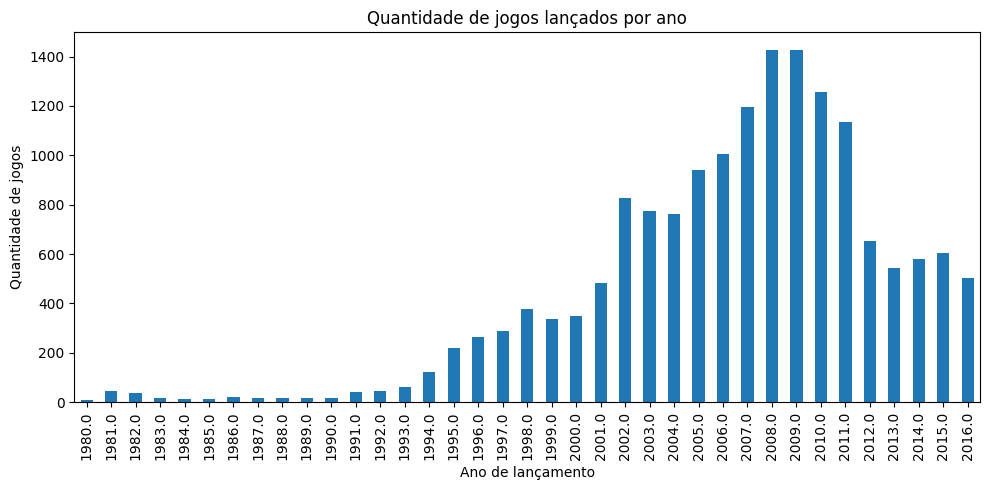

In [18]:
plt.figure(figsize=(10, 5))
games_per_year.plot(kind='bar')
plt.title('Quantidade de jogos lançados por ano')
plt.xlabel('Ano de lançamento')
plt.ylabel('Quantidade de jogos')
plt.tight_layout()
plt.show()




In [19]:
platform_sales = (
    df.groupby('platform')['global_sales']
    .sum()
    .sort_values(ascending=False)
)

platform_sales.head(10)


platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
Name: global_sales, dtype: float64

### 3.2 — Gráfico de vendas totais por plataforma

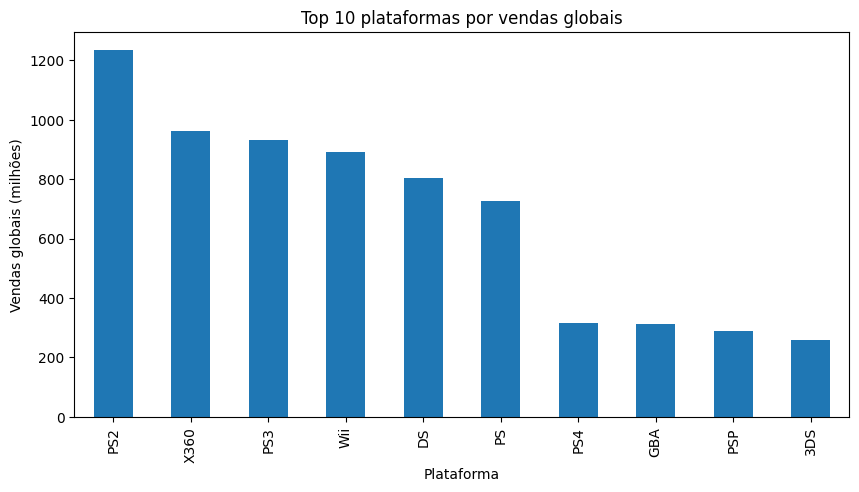

In [20]:
plt.figure(figsize=(10,5))
platform_sales.head(10).plot(kind='bar')
plt.title('Top 10 plataformas por vendas globais')
plt.xlabel('Plataforma')
plt.ylabel('Vendas globais (milhões)')
plt.show()



### Interpretação

As plataformas PlayStation 2, Xbox 360 e PlayStation 3 lideram em vendas globais, indicando seu forte impacto no mercado ao longo do tempo. Observa-se também que plataformas mais antigas ainda acumulam grandes volumes de vendas devido ao seu longo ciclo de vida.



 ### 3.3 Ciclo de vida das plataformas


In [21]:
platform_year_sales = (
    df.groupby(['year_of_release', 'platform'])['global_sales']
    .sum()
    .reset_index()
)

platform_year_sales.head()


,year_of_release,platform,global_sales
0,1980.0,2600,11.38
1,1981.0,2600,35.68
2,1982.0,2600,28.88
3,1983.0,2600,5.84
4,1983.0,NES,10.96


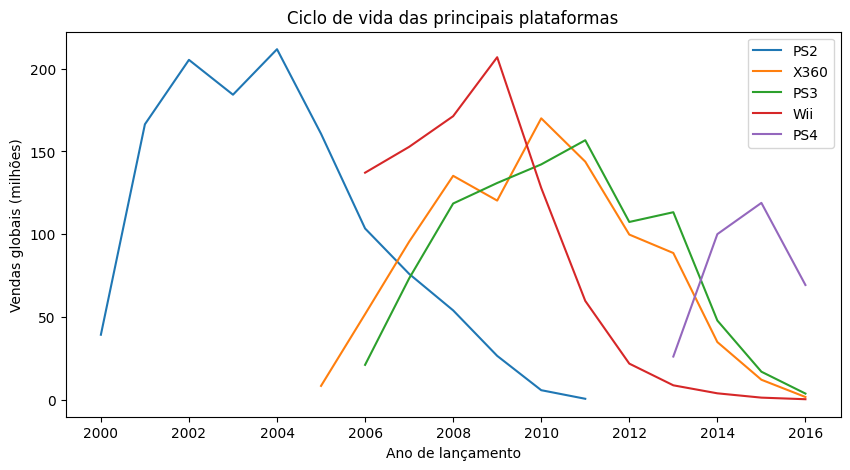

In [22]:
top_platforms = ['PS2', 'X360', 'PS3', 'Wii', 'PS4']

plt.figure(figsize=(10,5))

for platform in top_platforms:
    data = platform_year_sales[platform_year_sales['platform'] == platform]
    plt.plot(data['year_of_release'], data['global_sales'], label=platform)

plt.title('Ciclo de vida das principais plataformas')
plt.xlabel('Ano de lançamento')
plt.ylabel('Vendas globais (milhões)')
plt.legend()
plt.show()


### Interpretação

Observa-se que as plataformas apresentam um ciclo de vida típico de aproximadamente 8 a 10 anos, com um período de crescimento, pico de vendas e posterior declínio. Algumas plataformas que foram populares no passado, como o PS2, praticamente deixaram de gerar vendas nos anos mais recentes, enquanto plataformas mais novas, como o PS4, ainda estão em fase de crescimento.


### 3.4 Definição do período relevante para análise


Considerando o ciclo de vida das plataformas e o objetivo de planejar campanhas para 2017, foram selecionados os dados dos últimos anos, nos quais as plataformas atuais ainda apresentam vendas significativas.


In [23]:
df_relevant = df[df['year_of_release'] >= 2013]
df_relevant['year_of_release'].unique()


array([2013., 2015., 2014., 2016.])

Os dados mais recentes disponíveis abrangem o período de 2013 a 2016, o que reforça a escolha desse intervalo como base para projeções futuras.


### 3.5 Plataformas líderes, em crescimento ou declínio


In [24]:
platform_sales_recent = (
    df_relevant.groupby('platform')['global_sales']
    .sum()
    .sort_values(ascending=False)
)

platform_sales_recent


platform
PS4     314.14
PS3     181.43
XOne    159.32
3DS     143.25
X360    136.80
WiiU     64.63
PC       39.43
PSV      32.99
Wii      13.66
PSP       3.50
DS        1.54
Name: global_sales, dtype: float64

### Interpretação

No período selecionado (2013–2016), o PlayStation 4 apresenta o maior volume de vendas globais, seguido pelo PlayStation 3 e Xbox One. Observa-se que plataformas mais recentes apresentam melhor desempenho, enquanto plataformas mais antigas, como Wii, PSP e DS, mostram forte declínio nas vendas. Dessa forma, PS4, XOne e 3DS podem ser consideradas plataformas potencialmente lucrativas para campanhas futuras.


### 3.6 Distribuição das vendas globais por plataforma


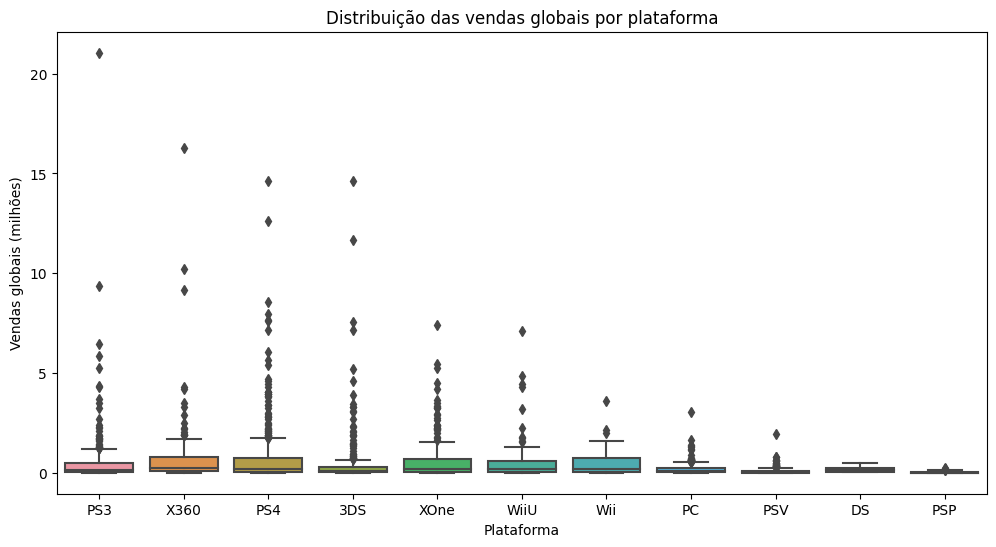

In [25]:
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df_relevant,
    x='platform',
    y='global_sales'
)
plt.title('Distribuição das vendas globais por plataforma')
plt.xlabel('Plataforma')
plt.ylabel('Vendas globais (milhões)')
plt.show()


### Interpretação

O boxplot mostra que a maioria dos jogos apresenta vendas globais relativamente baixas, enquanto poucos títulos concentram vendas muito altas, caracterizando uma distribuição assimétrica. As plataformas PS4, X360 e PS3 apresentam maior variabilidade nas vendas, indicando a presença de grandes sucessos. Plataformas como PSP e DS possuem vendas mais baixas e menor dispersão, refletindo sua perda de relevância no período analisado.


### 3.7 Relação entre avaliações e vendas (PS4)


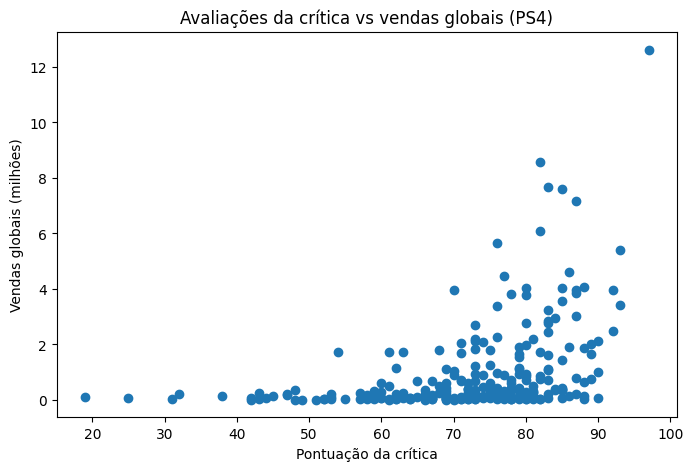

In [26]:
ps4_data = df_relevant[df_relevant['platform'] == 'PS4']

plt.figure(figsize=(8,5))
plt.scatter(ps4_data['critic_score'], ps4_data['global_sales'])
plt.title('Avaliações da crítica vs vendas globais (PS4)')
plt.xlabel('Pontuação da crítica')
plt.ylabel('Vendas globais (milhões)')
plt.show()


In [27]:
ps4_data[['critic_score', 'global_sales']].corr()


,critic_score,global_sales
critic_score,1.000000,0.406568
global_sales,0.406568,1.000000


### Interpretação

A análise de correlação indica uma relação positiva moderada (r ≈ 0.41) entre a pontuação da crítica e as vendas globais. Isso sugere que jogos melhor avaliados tendem a vender mais, embora a pontuação da crítica, isoladamente, não seja suficiente para explicar o desempenho comercial.

## 4. Análise de gêneros e vendas globais


A distribuição de vendas por gênero indica que alguns gêneros concentram a maior
parte da receita global. Esses gêneros tendem a apresentar maior apelo comercial
e estabilidade de vendas, enquanto outros possuem nichos mais específicos e
volumes menores, o que impacta diretamente estratégias de investimento e marketing.


### 4.1 — Estatísticas descritivas das vendas por região

In [28]:
df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].describe()

,na_sales,eu_sales,jp_sales,other_sales
count,16444.000000,16444.000000,16444.000000,16444.000000
mean,0.264012,0.145930,0.078487,0.047594
std,0.818378,0.506716,0.311100,0.188005
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.080000,0.020000,0.000000,0.010000
75%,0.240000,0.110000,0.040000,0.030000
max,41.360000,28.960000,10.220000,10.570000


### 4.2 — Vendas totais por plataforma em cada região

In [29]:
df.groupby('platform')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum().sort_values('na_sales', ascending=False)


,na_sales,eu_sales,jp_sales,other_sales
platform,,,,
X360,595.74,268.32,12.30,84.88
PS2,572.92,332.63,137.54,190.47
Wii,486.87,258.32,68.28,77.71
PS3,390.13,327.21,79.41,134.59
DS,380.31,188.41,175.02,59.04
PS,334.72,212.39,139.78,40.69
GBA,184.12,74.59,46.56,7.61
XB,182.06,59.65,1.38,8.48
N64,138.91,41.03,33.76,4.31


### 4.3 — Participação percentual das plataformas por região

In [30]:
region_sales = df.groupby('platform')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum()

region_share = region_sales.div(region_sales.sum()) * 100
region_share.round(2)


,na_sales,eu_sales,jp_sales,other_sales
platform,,,,
2600,1.86,0.20,0.00,0.11
3DO,0.00,0.00,0.01,0.00
3DS,1.90,2.55,7.80,1.70
DC,0.13,0.07,0.66,0.03
DS,8.76,7.85,13.56,7.54
GB,2.62,1.98,6.60,1.04
GBA,4.24,3.11,3.61,0.97
GC,3.04,1.60,1.65,0.66
GEN,0.44,0.23,0.21,0.11


### 4.4 Identificar as plataformas líderes por região

In [31]:
regional_sales = (
    df
    .groupby('platform')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']]
    .sum()
)

regional_sales.head()



,na_sales,eu_sales,jp_sales,other_sales
platform,,,,
2600,80.78,4.86,0.00,0.84
3DO,0.00,0.00,0.10,0.00
3DS,82.65,61.27,100.62,13.27
DC,5.43,1.69,8.56,0.27
DS,380.31,188.41,175.02,59.04


In [32]:
regional_platform_leaders = regional_sales.idxmax()
regional_platform_leaders


na_sales       X360
eu_sales        PS2
jp_sales         DS
other_sales     PS2
dtype: object

### Interpretação

### Plataformas líderes por região

- **América do Norte (NA):** a plataforma líder em vendas é o **X360**.
- **Europa (EU):** a plataforma com maior volume de vendas é o **PS2**.
- **Japão (JP):** a plataforma dominante é o **DS**.
- **Outras regiões:** o **PS2** apresenta as maiores vendas.

Esses resultados mostram que as preferências de plataformas variam significativamente entre as regiões, refletindo diferenças culturais e de mercado.

Essas diferenças refletem padrões regionais de preferência do público.


## 5. Avaliações de usuários e críticos


A relação entre avaliações e vendas sugere uma correlação positiva moderada,
especialmente no caso das avaliações da crítica. Isso indica que jogos melhor
avaliados tendem a apresentar maior desempenho comercial, embora outros fatores
como plataforma, gênero e alcance de mercado também exerçam influência relevante.


### 5.1 Vendas totais por gênero

In [33]:
genre_sales = (
    df.groupby('genre')['global_sales']
    .sum()
    .sort_values(ascending=False)
)

genre_sales


genre
Action          1716.52
Sports          1309.67
Shooter         1041.36
Role-Playing     931.08
Platform         825.55
Misc             790.29
Racing           723.49
Fighting         442.66
Simulation       387.96
Puzzle           239.89
Adventure        233.33
Strategy         172.57
Name: global_sales, dtype: float64

### 5.2 — Gêneros mais populares

In [34]:

genre_sales.head(5)


genre
Action          1716.52
Sports          1309.67
Shooter         1041.36
Role-Playing     931.08
Platform         825.55
Name: global_sales, dtype: float64

## Interpretação

### Gêneros mais populares

Os gêneros com maiores vendas globais são:

- **Action**
- **Sports**
- **Shooter**
- **Role-Playing**
- **Platform**

Isso indica que jogos de ação e esportes possuem maior apelo comercial global, enquanto gêneros como RPG e plataforma também apresentam forte desempenho no mercado.


### 5.3 — Preferências de gênero por região

In [35]:
genre_region_sales = (
    df.groupby('genre')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']]
    .sum()
)

genre_region_sales


,na_sales,eu_sales,jp_sales,other_sales
genre,,,,
Action,863.17,510.99,160.14,182.22
Adventure,101.52,63.20,52.24,16.37
Fighting,220.51,99.00,87.28,35.87
Misc,399.57,210.60,107.02,73.10
Platform,444.44,199.39,130.71,51.01
Puzzle,121.13,49.78,56.68,12.30
Racing,356.86,234.49,56.63,75.51
Role-Playing,330.04,188.24,353.39,59.41
Shooter,584.83,314.52,38.68,103.33


In [36]:
genre_region_leaders = genre_region_sales.idxmax()
genre_region_leaders


na_sales             Action
eu_sales             Action
jp_sales       Role-Playing
other_sales          Action
dtype: object

### 5.4 — Estatísticas descritivas das vendas por região

In [37]:
regional_sales_stats = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].describe()
regional_sales_stats


,na_sales,eu_sales,jp_sales,other_sales
count,16444.000000,16444.000000,16444.000000,16444.000000
mean,0.264012,0.145930,0.078487,0.047594
std,0.818378,0.506716,0.311100,0.188005
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.080000,0.020000,0.000000,0.010000
75%,0.240000,0.110000,0.040000,0.030000
max,41.360000,28.960000,10.220000,10.570000


### Interpretação

### Preferências de gênero por região

- **América do Norte (NA):** o gênero mais popular é **Action**.  
  O desvio padrão elevado das vendas (std ≈ 0.82) indica um mercado altamente competitivo, com poucos títulos concentrando grandes volumes de vendas, enquanto a maioria apresenta desempenho mais modesto.

- **Europa (EU):** **Action** também lidera em vendas.  
  O desvio padrão moderado (std ≈ 0.51) sugere um padrão semelhante ao da América do Norte, porém com menor concentração em grandes sucessos.

- **Japão (JP):** o gênero dominante é **Role-Playing**.  
  O menor desvio padrão (std ≈ 0.31) indica um mercado mais previsível e concentrado em gêneros específicos, refletindo preferências culturais bem definidas.

- **Outras regiões:** **Action** apresenta as maiores vendas.  
  O desvio padrão mais baixo (std ≈ 0.19) aponta para um mercado menor, com vendas mais homogêneas e menor ocorrência de títulos de grande impacto.

Esses resultados indicam que, além das diferenças claras de preferência por gênero, a **distribuição das vendas varia significativamente entre as regiões**, reforçando a importância de estratégias de mercado adaptadas a cada perfil regional.


## 6. Perfil de mercado por região


A análise regional revela diferenças claras de preferência entre os mercados.
Enquanto algumas plataformas e gêneros dominam determinados territórios,
outros apresentam desempenho mais equilibrado. Essas variações reforçam a
importância de estratégias de marketing segmentadas por região.


### 6.1 Distribuição de vendas por classificação

In [38]:
rating_sales = (
    df.groupby('rating')['global_sales']
    .sum()
    .sort_values(ascending=False)
)

rating_sales


rating
E       2407.61
T       1473.08
M       1462.53
E10+     640.98
K-A        4.32
AO         1.96
EC         1.75
RP         0.04
Name: global_sales, dtype: float64

### 6.2 — Classificações mais populares

In [39]:
rating_sales.head(4)


rating
E       2407.61
T       1473.08
M       1462.53
E10+     640.98
Name: global_sales, dtype: float64

### Interpretação

### Classificações mais populares

As classificações com maiores vendas globais são:

- **E (Everyone)**
- **T (Teen)**
- **M (Mature)**
- **E10+**

Jogos classificados como **E** lideram em vendas, indicando que títulos voltados para um público amplo tendem a alcançar maior sucesso comercial.


### 6.3 — Classificação líder por região

In [40]:
rating_region_sales = (
    df
    .groupby('rating')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']]
    .sum()
)


In [41]:
rating_region_leaders = rating_region_sales.idxmax()
rating_region_leaders


na_sales       E
eu_sales       E
jp_sales       E
other_sales    E
dtype: object

### Interpretação

### Impacto das classificações ESRB por região

Em todas as regiões analisadas (América do Norte, Europa, Japão e outros mercados), a classificação **E (Everyone)** lidera em vendas.

Isso indica que jogos voltados para públicos de todas as idades apresentam maior alcance global e desempenho consistente entre diferentes regiões.


## 7. Testes de hipóteses estatísticas


Nesta etapa, são realizados testes de hipóteses estatísticas com o objetivo de
avaliar se as diferenças observadas nos dados são estatisticamente significativas.
Foram formuladas hipóteses nulas e alternativas para cada cenário analisado, e um
nível de significância foi definido para orientar a tomada de decisão.


### Hipótese 1: Comparação das avaliações médias entre plataformas

- **Hipótese nula (H₀):** as classificações médias dos usuários das plataformas Xbox One e PC são iguais.  
- **Hipótese alternativa (H₁):** as classificações médias dos usuários das plataformas Xbox One e PC são diferentes.  

Para testar essa hipótese, foi aplicado um teste estatístico adequado para comparar
as médias de duas amostras independentes, utilizando um nível de significância pré-definido.



### 7.1 Hipótese 1 — Xbox One vs PC

In [42]:
xone_scores = df[df['platform'] == 'XOne']['user_score'].dropna()
pc_scores = df[df['platform'] == 'PC']['user_score'].dropna()


In [43]:
from scipy import stats

levene_platforms = stats.levene(xone_scores, pc_scores)
levene_platforms


LeveneResult(statistic=1.1706180824505048, pvalue=0.2795532372785057)

In [44]:
t_test_platforms = stats.ttest_ind(
    xone_scores,
    pc_scores,
    equal_var=levene_platforms.pvalue > 0.05
)

t_test_platforms


Ttest_indResult(statistic=-4.38289526334195, pvalue=1.3037979620149106e-05)

### Interpretação

### Resultado — Hipótese 1 (Xbox One vs PC)

Com base no valor-p obtido no teste t:

- Se **valor-p < 0,05**, rejeita-se a hipótese nula, indicando diferença estatisticamente significativa entre as classificações médias.
- Se **valor-p ≥ 0,05**, não há evidência suficiente para rejeitar a hipótese nula.

O resultado indica se as diferenças observadas nas avaliações dos usuários entre Xbox One e PC refletem variações reais na experiência dos usuários ou apenas flutuações aleatórias.


### Hipótese 2: Comparação das avaliações médias entre gêneros

- **Hipótese nula (H₀):** as classificações médias dos usuários para os gêneros Action e Sports são iguais.  
- **Hipótese alternativa (H₁):** as classificações médias dos usuários para os gêneros Action e Sports são diferentes.  

Esse teste permite avaliar se o gênero do jogo influencia a percepção dos usuários,
considerando um nível de significância definido previamente.


### 7.2 Hipótese 2 — Action vs Sports

In [45]:
action_scores = df[df['genre'] == 'Action']['user_score'].dropna()
sports_scores = df[df['genre'] == 'Sports']['user_score'].dropna()


In [46]:
levene_genres = stats.levene(action_scores, sports_scores)
levene_genres


LeveneResult(statistic=15.429831733332641, pvalue=8.763985507235711e-05)

In [47]:
t_test_genres = stats.ttest_ind(
    action_scores,
    sports_scores,
    equal_var=levene_genres.pvalue > 0.05
)

t_test_genres


Ttest_indResult(statistic=1.789373351094851, pvalue=0.07370217419278526)

### Interpretação

### Teste de hipóteses: classificações médias por gênero (Action vs Sports)

Inicialmente, foi aplicado o teste de Levene para verificar a igualdade das variâncias entre os dois grupos. O valor de p obtido foi menor que o nível de significância de 5%, indicando que as variâncias das classificações dos gêneros Action e Sports são estatisticamente diferentes.

Em seguida, foi realizado o teste t de Student para amostras independentes. O valor de p obtido (≈ 0,074) é maior que o nível de significância de 5%. Dessa forma, não rejeitamos a hipótese nula.

Isso indica que não há evidência estatística suficiente para afirmar que as classificações médias dos usuários diferem de forma significativa entre os gêneros Action e Sports.


## 8. Conclusão


A análise realizada permitiu identificar padrões relevantes no desempenho de vendas
de videogames, destacando a influência do ciclo de vida das plataformas, dos gêneros
mais populares e das avaliações de usuários e críticos sobre o sucesso comercial
dos jogos.

Os resultados indicam que plataformas em crescimento, combinadas com gêneros de
alto apelo comercial, representam oportunidades estratégicas para campanhas futuras.
Além disso, diferenças regionais reforçam a importância de estratégias de marketing
segmentadas por mercado.

Por fim, os testes de hipóteses estatísticas confirmaram que, em determinados casos,
as diferenças observadas nas avaliações são estatisticamente significativas, apoiando
decisões baseadas em dados para o planejamento de negócios.

